In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

execfile('python_libraries.py')

# word embedding features
dta = pd.read_pickle('../../data/features_pkl/dta.pickle')
embedding_df = pd.read_pickle('../../data/features_pkl/embedding_df_ndim_100_window_5_min_count_3.pickle')

# other features
cuisine_df = pd.read_pickle('../../data/features_pkl/cuisine.pickle')
dta = pd.read_pickle('../../data/features_pkl/dta.pickle')
zip_code_df = pd.read_pickle('../../data/features_pkl/zip_code_df.pickle')


CV_model = True # False True
model_type = 'RF' # 'RF' 'SVR'
ndim = 100
search_type = 'random' # 'random' 'grid'

## Predictive Models to Try
kf = KFold(n_splits = 3, shuffle = True, random_state = 5)



In [5]:
if CV_model:
    if model_type=='RF':
        max_depth = [None, 5, 10]
        min_samples_leaf = [0.0005, 0.01, 0.05, 0.1]
        min_samples_split = [2, 5, 10]
        n_estimators = [100, 200, 500]
        max_features = [None, 0.25, 0.5, 0.75]
        param_grid = {'max_features': max_features,
            'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                    'n_estimators':n_estimators}
        clf = sklearn.ensemble.RandomForestRegressor(random_state = 123)
        if search_type == 'grid':
            model_full = GridSearchCV(estimator = clf,
                         param_grid = param_grid,
                         cv = kf, verbose=0,
                         n_jobs = 3, scoring = 'neg_mean_squared_error')
        if search_type == 'random':
            model_full = RandomizedSearchCV(estimator = clf, random_state = 123,
                                      param_distributions = param_grid,
                                      cv = kf, verbose=0, n_iter = 25,
                                      n_jobs = 5, scoring = 'neg_mean_squared_error')
    if model_type =='SVR':
        Cs = [0.001, 0.01, 0.1, 1, 10, 100]
        param_grid = {'C': Cs}
        model_full = GridSearchCV(estimator = SVR(), param_grid = param_grid, cv=kf,
                             verbose = 0, n_jobs = 3, scoring = 'neg_mean_squared_error')
else:
    if model_type=='RF':
        model_full = sklearn.ensemble.RandomForestRegressor(n_estimators=200)
    if model_type=='SVR':
        model_full = SVR(C=100)




In [6]:
dta_analysis_tmp = dta.copy()

dta_analysis = dta_analysis_tmp[['inspection_id', 'inspection_average_prev_penalty_scores',
                                 'inspection_prev_penalty_score', 'inspection_penalty_score',
                                 'review_count', 'non_positive_review_count', 'average_review_rating']]
# merge embeddings
dta_analysis = dta_analysis.merge(embedding_df,
              on = 'inspection_id',
              how = 'left')

# merge other features
dta_analysis = dta_analysis.merge(cuisine_df,
              on = 'inspection_id',
              how = 'left')
dta_analysis = dta_analysis.merge(zip_code_df,
              on = 'inspection_id',
              how = 'left')

subset = np.array(dta_analysis.columns)[np.array(dta_analysis.columns)!='inspection_penalty_score']
subset=subset[subset!='inspection_id']
counter = 0
feature_set_without_embedding = subset[~np.in1d(subset,embedding_df.columns[embedding_df.columns!='inspection_id'])]
feature_set_without_embedding = feature_set_without_embedding[~np.in1d(feature_set_without_embedding,[ 'review_count', 'non_positive_review_count', 'average_review_rating'])]

#feature_set = [[feature_set_without_embedding], [subset]]

#subset = ['review_count']
subset = feature_set_without_embedding

In [7]:
print 'counter: ', counter
print 'features: ', subset ## ignore this value for 9
kf = KFold(n_splits=10,     # 10-fold CV is used in paper
      shuffle = True,      # assuming they randomly select train/test
      random_state = 123)  # random.seed for our own internal replication purposes
mse_features = []
m = 0
for train, test in kf.split(dta_analysis):
    print m
    x_train = dta_analysis.iloc[train,:][subset]
    if m == 0:
        print 'columns used as sanity check: ',x_train.columns
        print len(x_train.columns)
        print len(subset)
    y_train = dta_analysis.inspection_penalty_score.iloc[train]
    x_test = dta_analysis.iloc[test,:][subset]
    y_test = dta_analysis.inspection_penalty_score.iloc[test]


counter:  0
features:  ['inspection_average_prev_penalty_scores' 'inspection_prev_penalty_score'
 'Afghan' 'African' 'American(New)' 'American(Traditional)' 'AsianFusion'
 'Australian' 'Barbeque' 'Basque' 'Belgian' 'Brazilian' 'Breakfast&Brunch'
 'British' 'Buffets' 'Burgers' 'Cafes' 'Cajun/Creole' 'Cambodian'
 'Cantonese' 'Caribbean' 'Cheesesteaks' 'ChickenWings' 'Chinese'
 'Colombian' 'ComfortFood' 'Creperies' 'Cuban' 'Delis' 'DimSum' 'Diners'
 'Egyptian' 'Ethiopian' 'FastFood' 'Filipino' 'Fish&Chips' 'Fondue'
 'FoodCourt' 'FoodStands' 'French' 'Gastropubs' 'German' 'Gluten-Free'
 'Greek' 'Haitian' 'Halal' 'Hawaiian' 'Himalayan/Nepalese' 'HotDogs'
 'HotPot' 'Indian' 'Indonesian' 'Irish' 'Italian' 'Japanese' 'Korean'
 'Kosher' 'Laotian' 'LatinAmerican' 'Lebanese' 'Live/RawFood' 'Malaysian'
 'Mediterranean' 'Mexican' 'MiddleEastern' 'ModernEuropean' 'Mongolian'
 'Moroccan' 'Pakistani' 'Persian/Iranian' 'Pizza' 'Polish' 'PuertoRican'
 'Russian' 'Salad' 'Salvadoran' 'Sandwiches' 'Scandin

## Justify Hyperparameter Range

In [8]:
#        max_depth = [None, 5, 10]
#        min_samples_leaf = [0.0005, 0.01, 0.05, 0.1]
#        min_samples_split = [2, 5, 10]
#        n_estimators = [100, 200, 500]
#        max_features = [None, 0.25, 0.5, 0.75]



In [9]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from collections import OrderedDict
RANDOM_STATE = 123

ensemble_clfs = [
    ("RF, max_depth=None",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, oob_score=True,max_depth = None,
                               max_features=0.25,
                                               min_samples_leaf = 0.01,
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=5",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, 
                                               max_features=0.25,
                                               max_depth = 5,
                                               min_samples_leaf = 0.01,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=10",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, 
                                               max_features=0.25,
                                               max_depth = 10,
                                               min_samples_leaf = 0.01,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



In [ ]:
min_estimators = 100
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        #print i
        clf.set_params(n_estimators=i)
        clf.fit(x_train,
                  np.ravel(y_train))

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))


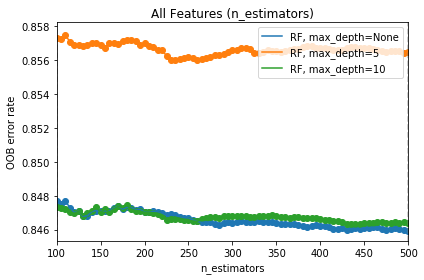

In [35]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    plt.scatter(xs, ys)#, label=label)

plt.axvline(100, color = 'gray', alpha = 0.5, ls = '--')
plt.axvline(500, color = 'gray', alpha = 0.5, ls = '--')


plt.xlim(min_estimators, max_estimators)
#plt.ylim(0.9, 1.015)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title('All Features (n_estimators)')
plt.legend(loc="upper right")

plt.tight_layout()
pp = PdfPages("./RF_all_features_except_embedding_final.pdf")
pp.savefig()
pp.close()